In [1]:
from ephys_queries import select_analog_signal_data, select_spike_times, select_stft
from ephys_queries import db_setup_core
from dotenv import load_dotenv
from pathlib import Path

In [49]:
from spiketimes.df.statistics import ifr_by
from spiketimes.df.binning import which_bin
from spiketimes.utils import p_adjust

In [415]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.ndimage import gaussian_filter1d, gaussian_filter
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from itertools import combinations
from scipy.stats import zscore

In [422]:
def correlate(x1, x2):
    if len(x1) < 3:
        return pd.Series({"r": np.nan, "p": np.nan})
    r, p = pearsonr(x1, x2)
    return pd.Series({"r": r, "p": p})


def db_normalise(x, ref):
    return 10 * np.log10(x / ref)

def delta_to_theta(x):
    delta = x.loc[lambda y: y.band == "delta"].power
    theta = x.loc[lambda y: y.band == "theta"].power
    return delta / theta

def frequency_heatmap(df, 
                      frequency_col="frequency", 
                      data_col="fft_value", 
                      time_col="timepoint_s",
                      vmin=None, vmax=None,
                      sigma=1,
                      figsize=(10, 5),
                      zscore_norm=False,
                      db_norm=True,
                      ax=None, 
                      imshow_kwargs=None
                     ):
    if imshow_kwargs is None:
        imshow_kwargs={}
    imshow_kwargs["cmap"] = "coolwarm" if "cmap" not in imshow_kwargs else imshow_kwargs["cmap"]
    imshow_kwargs["aspect"] = "auto" if "aspect" not in imshow_kwargs else imshow_kwargs["aspect"]
    if ax is None:
        f, ax = plt.subplots(figsize=figsize)
    dfp = (
        df
        .pivot(
            index=time_col,
            columns=frequency_col,
            values=data_col,
        )
    )
    dfp = pd.DataFrame(gaussian_filter(dfp.values, sigma))
    if db_norm:
        dfp = dfp.apply(lambda x: db_normalise(x, x.mean()))
    if zscore_norm:
        dfp = dfp.apply(zscore)
    dfp = dfp.transpose()

    im = ax.imshow(dfp.iloc[::-1], vmin=vmin, vmax=vmax, **imshow_kwargs)

    # xticks
    n = dfp.shape[1]
    first_point = df[time_col].min() 
    time_interval = df.iloc[:5, :][time_col].diff().values[1]
        
    xticks = np.arange(0, n, (60 / time_interval) * 10)    
    ax.set_xticks(xticks)
    ax.set_xticklabels( first_point + xticks // (60 / time_interval))
    

    # yticks
    max_f = df[frequency_col].max()
    min_f = df[frequency_col].min()
    f = df[frequency_col].unique()[:5]
    f.sort()
    f_interval = np.diff(f)[1]

    ytick_labels = np.round(np.linspace(min_f, max_f, 5))
    yticks = np.arange(0, dfp.shape[0])
    yticks = yticks[np.isin(yticks, min_f +(ytick_labels / f_interval))]
    ax.set_yticks(yticks)
    ax.set_yticklabels(ytick_labels[::-1])

    plt.colorbar(im)
    return ax

In [344]:
data_dir = Path(".").absolute().parent / "data"
fig_dir = Path(".").absolute().parent / "figs"

# Load Data

In [4]:
group_names = ["acute_citalopram", 
            "acute_saline", 
            "acute_cit", 
            "acute_sal",
              "shock",
              "sham"]

block_name = "pre"
load_dotenv()
engine, metadata = db_setup_core()

In [516]:
signal_names = ["eeg_occ"]

df_fft = select_stft(engine, metadata, 
                               signal_names=signal_names,
                              block_name=block_name, 
                              group_names=group_names
                                   )
df_spikes = (
    select_spike_times(engine, metadata, 
                              block_name=block_name, 
                              group_names=group_names,
                      session_names = df_fft.session_name.unique().tolist())
    .assign(spiketimes=lambda x: x["spike_time_samples"].divide(30000))
)

In [389]:
example_session = df_fft.session_name.unique()[1]

In [391]:
df_analog = select_analog_signal_data(engine, metadata,
            signal_names=[signal_name],
             block_name=block_name,
             session_names=[example_session]
            )

In [354]:
dfb = pd.read_csv(data_dir / "baseline.csv")

# Example Signal

## Plot One Session

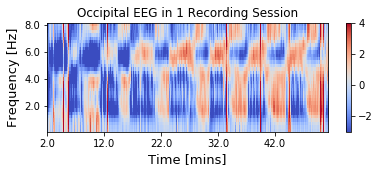

In [427]:
ax = (
    df_fft
    .loc[lambda x: x.frequency < 8]
    .loc[lambda x: x.session_name == x.session_name.unique()[1]]
    .pipe(lambda x: frequency_heatmap(x, sigma=2,
                                      vmin=-3, vmax=4,
                                      zscore_norm=False, db_norm=True,
                                      imshow_kwargs={"cmap": "coolwarm"},
                                     figsize=(6.3, 2))
         )
)
ax.set_title("Occipital EEG in 1 Recording Session")
ax.set_xlabel("Time [mins]", fontsize=13)
ax.set_ylabel("Frequency [Hz]", fontsize=13)

plt.savefig(fig_dir / "Example EEG.svg")

## Correlation Between Spikes & \{$\delta$, $\theta$, $\frac{\delta}{\theta}$\}

In [272]:
bins = df_fft.timepoint_s.unique()

df1 = (
    df_fft
    .loc[lambda x: (x.frequency < 8) & (x.frequency > 0)]
    .assign(
        band = lambda x: x.frequency.apply(lambda y: "delta" if y < 4 else "theta")
    )
)
df_rythm_ts = (
    df1
    .groupby(["session_name", "signal_name", "timepoint_s", "group_name", "band"])
    .apply(lambda x: np.mean(x.fft_value))
    .reset_index()
    .rename(columns={0: "power"})
    .pivot_table(index=["session_name", "timepoint_s"], columns="band", values="power")
    .reset_index()
    .assign(
        delta_smooth= lambda x: gaussian_filter1d(x.delta, 10),
        theta_smooth= lambda x: gaussian_filter1d(x.theta, 10),
        delta_to_theta = lambda x: x.delta / x.theta,
        delta_to_theta_smooth = lambda x: x.delta_smooth / x.theta_smooth
           )
)

df_rythm_ts_spikes = (
    which_bin(df_spikes, bins, spiketimes_col="spiketimes")
        .groupby(["session_name", "bin_values", "neuron_id"])
    .apply(lambda x: len(x))
    .reset_index()
    .rename(columns={0:"spike_counts", "bin_values": "timepoint_s"})
    .merge(df_rythm_ts)
)

In [387]:
tmp_res = (
    df_rythm_ts_spikes
    .groupby("neuron_id")
    .apply(lambda x: correlate(x.spike_counts, x.delta_to_theta_smooth))
    .assign(
        p = lambda x: p_adjust(x.p),
    )
    .rename(columns={'r':"DeltaThataRatio_Spike_Corr",
                    "p": "p_DeltaThataRatio_Spike_Corr"})
    .reset_index()
)
tmp_res = (
    df_rythm_ts_spikes
    .groupby("neuron_id")
    .apply(lambda x: correlate(x.spike_counts, x.delta_smooth))
    .assign(
        p = lambda x: p_adjust(x.p),
    )
    .rename(columns={'r':"Delta_Spike_Corr",
                    "p": "p_Delta_Spike_Corr"})
    .reset_index()
    .merge(tmp_res)
)
tmp_res = (
    df_rythm_ts_spikes
    .groupby("neuron_id")
    .apply(lambda x: correlate(x.spike_counts, x.theta_smooth))
    .assign(
        p = lambda x: p_adjust(x.p),
    )
    .rename(columns={'r':"Theta_Spike_Corr",
                    "p": "p_Theta_Spike_Corr"})
    .reset_index()
    .merge(tmp_res)
)
(
    tmp_res
    .merge(dfb[["neuron_id","cluster", "group_name", "session_name"]])
    .to_csv(data_dir / "EEG_spikerate_corr.csv", index=False)
)

## Correlation TS

In [275]:
def pairwise_rolling_corr(df, rolling_periods=10, value_col="spike_counts", 
                          time_col="timepoint_s", 
                         by_col="neuron_id"):
    tmp = (
        df
        .pivot(columns=by_col, index=time_col, values=value_col)
        .rolling(rolling_periods)
        .corr()
        .reset_index()
    )
    tmp.columns.name = ""
    
    neurons = df[by_col].unique().tolist()
    combs = [*combinations(neurons, 2)]
    
    return (
        tmp
        .melt(
            id_vars=[by_col, time_col], 
            var_name="neuron_2", 
            value_name="rolling_corr"
        )
        .rename(columns={"neuron_id": "neuron_1"})
        .assign(neuron_comb = lambda x: x.apply(lambda row: (int(row.neuron_1), int(row.neuron_2)),
                                                axis=1)
               )
        .loc[lambda x: x.neuron_comb.isin(combs)]
    )

In [323]:
frames = []
for session in df_spikes.session_name.unique():
    df_sub = (
        df_rythm_ts_spikes
        .loc[lambda x: x.session_name == session]
    )
    df_res = pairwise_rolling_corr(df_sub)
    frames.append(df_res.assign(session_name=session).merge(df_rythm_ts))

df_rolling_comp = pd.concat(frames)

In [324]:
df_rolling_comp = df_rolling_comp.merge(df_rythm_ts)

In [386]:
df_rolling_res = (
    df_rolling_comp
    .dropna()
    .loc[lambda x: ~np.isinf(x.rolling_corr)]
    .groupby(["neuron_1", "neuron_2"])
    .apply(lambda x: correlate(x.delta_to_theta_smooth, x.rolling_corr))
    .reset_index()
    .assign(p_ad = lambda x: p_adjust(x.p))
    .merge(dfb[["neuron_id", "cluster", "session_name", "group_name"]], 
           left_on="neuron_1", right_on="neuron_id")
    .drop("neuron_id", axis=1)
    .rename(columns={"cluster": "spiketrain_1_cluster"})
    .merge(dfb[["neuron_id", "cluster"]], left_on="neuron_2", right_on="neuron_id")
    .rename(columns={"cluster": "spiketrain_2_cluster"})
    .drop("neuron_id", axis=1)
        .assign(has_sr=lambda x: 
                x.apply(lambda y: (y.spiketrain_1_cluster == "slow_regular") or (y.spiketrain_2_cluster== "slow_regular"),
                       axis=1),
            has_sir=lambda x: 
                x.apply(lambda y: (y.spiketrain_1_cluster == "slow_irregular") or (y.spiketrain_2_cluster== "slow_irregular"),
                       axis=1),
            has_ff=lambda x: 
                x.apply(lambda y: (y.spiketrain_1_cluster == "fast_firing") or (y.spiketrain_2_cluster== "fast_firing"),
                       axis=1)
           )
    .assign(comb= lambda x: x.apply(lambda y: 
                                    "sr_sr" if y.has_sr and (not y.has_sir) and (not y.has_ff)
                                   else "sr_sir" if y.has_sr and y.has_sir and (not y.has_ff)
                                   else "sr_ff" if y.has_sr and (not y.has_sir) and y.has_ff
                                   else "sir_sir" if (not y.has_sr) and y.has_sir and (not y.has_ff)
                                   else "sir_ff" if (not y.has_sr) and y.has_sir and y.has_ff
                                   else "ff_ff", axis=1
                                   )
           )
    .to_csv(data_dir / "Corr_RollingCorr_DetaTheta.csv", index=False)
    )